In [1]:
import pandas as pd

In [2]:
df = pd.read_csv("data/target_CHEMBL240-1.IC50_ready.csv.gz", compression="gzip")
df

,Standardized_SMILES,pchembl_value
0,Brc1cncc(COCC2(c3ccccc3)CCNCC2)c1,4.82
1,C1=NC(c2c[nH]c(-c3cc4c([nH]c5ccccc54)c(C4CCCCC...,6.70
2,C1=NC(c2c[nH]c(-c3cc4c([nH]c5ccccc54)c(C4CCCCC...,6.47
3,C1=NC(c2c[nH]c(-c3cc4c([nH]c5ccccc54)c(C4CCOCC...,5.39
4,C1=NCCC(c2c[nH]c(-c3cc4c([nH]c5ccccc54)c(C4CCC...,7.05
...,...,...
1257,c1ccc2c3c([nH]c2c1)C(C1CCOCC1)NC(c1nc(-c2cscn2...,5.36
1258,c1ccc2c3c([nH]c2c1)C(C1CCOCC1)NC(c1nc(C24CC5CC...,6.30
1259,c1ccc2c3c([nH]c2c1)C(C1CCOCC1)NC(c1nc(C2CCCCC2...,6.87
1260,c1cncc(-c2c[nH]c(C3Cc4c([nH]c5ccccc45)C(C4CCCC...,6.72


In [3]:
from rdkit import Chem
from rdkit.Chem import Descriptors
from pandarallel import pandarallel
pandarallel.initialize(progress_bar=False)

def calculate_molwt(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol:
        return Descriptors.MolWt(mol)
    return None

def calculate_logp(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol:
        return Descriptors.MolLogP(mol)
    return None
def calculate_QED(smiles):
    mol=Chem.MolFromSmiles(smiles)
    if mol:
        return Chem.QED.default(mol)
    return

df['MolWt'] =df['Standardized_SMILES'].apply(calculate_molwt)
df['LogP'] = df['Standardized_SMILES'].apply(calculate_logp)
df['QED'] = df['Standardized_SMILES'].apply(calculate_QED)

INFO: Pandarallel will run on 14 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.

https://nalepae.github.io/pandarallel/troubleshooting/


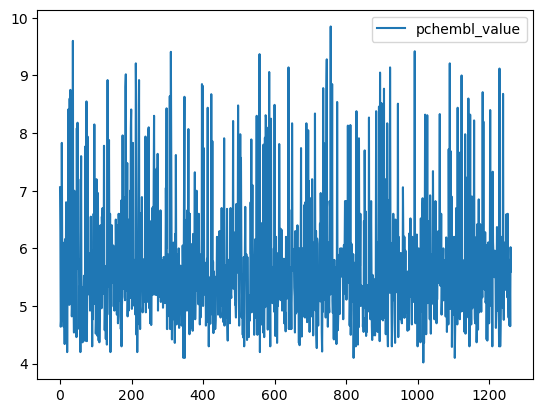

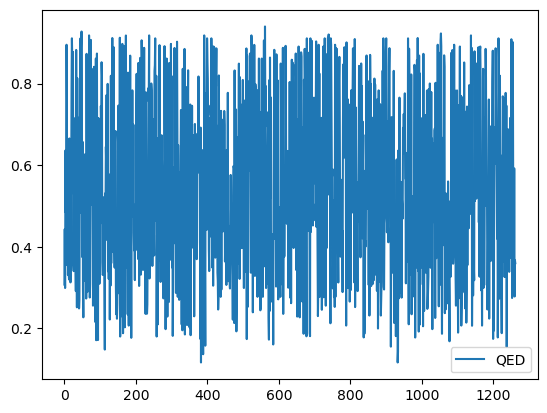

In [4]:
import random
df_copy=df = df.sample(frac=1).reset_index(drop=True)
df_copy.plot(y="pchembl_value",use_index=False) 
df_copy.plot(y="QED",use_index=False) 
df=df_copy

In [5]:
import pandas as pd
from rdkit import Chem
from rdkit.Chem import AllChem
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_predict, KFold
import numpy as np
import matplotlib.pyplot as plt

In [6]:
# Generate Morgan Fingerprints
def generate_fingerprints(smiles, radius=2, nBits=20488):
    mol = Chem.MolFromSmiles(smiles)
    if mol is not None:
        return np.array(AllChem.GetMorganFingerprintAsBitVect(mol, radius, nBits))
    else:
        return np.zeros((nBits,))

df['Fingerprints'] = df['Standardized_SMILES'].apply(generate_fingerprints)

# Prepare features and target
X = np.array(list(df['Fingerprints']))
y = df['pchembl_value'].values

In [7]:
smiles = df['Standardized_SMILES'].values

In [8]:
MolWt = df['MolWt'].values
LogP = df['LogP'].values
QED=df['QED'].values

In [9]:
df

,Standardized_SMILES,pchembl_value,MolWt,LogP,QED,Fingerprints
0,c1ccc2c3c([nH]c2c1)C(C1CCOCC1)NC(c1nc(-c2csc4c...,7.06,454.599,6.12740,0.307318,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,O=C1COc2ccc(CNC34CCC(CCc5c(F)cnc6ccc(OC7CCC7)n...,6.30,533.604,4.23030,0.443121,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,COc1cc(N2C(=O)N(c3ccc(-c4ccc(C(=O)O)c(C)c4)cc3...,4.64,592.656,4.87024,0.298900,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,Cc1ccncc1-c1cc2c(=NC3CCC(C)(N)C3(C)C)c(C(N)=O)...,4.75,392.507,2.54342,0.636060,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,COc1cc2c(cc1CCN1CCN(C(=O)Cc3ccc(-n4cnnn4)cc3)C...,5.25,462.510,1.27070,0.483963,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
...,...,...,...,...,...,...
1257,Cc1nccc(N2C(=O)N(c3ccc(-c4ccc(C(=O)O)cc4C)cc3)...,4.66,576.657,5.17006,0.312373,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1258,CCC(NC(=O)c1ccc(Cl)cc1)C1C2CC(n3cnc4cc(F)c(F)c...,5.46,429.898,5.37360,0.591999,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1259,CCn1cc(C2(c3n[nH]c(=O)o3)NC(c3nc(-c4ccc(F)cn4)...,4.65,511.521,3.16370,0.278064,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1260,Cc1nc(C)c(-c2ccc(N3C(=O)N(c4cc(=O)[nH]cn4)C4(C...,6.02,555.664,4.22166,0.366732,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [10]:
#Now incorporate this sort of noise into df during the training

In [11]:
X.shape

(1262, 20488)

In [40]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
import scipy.stats as stats
from sklearn.metrics import mean_squared_error
from math import sqrt

def perform_cv(X, y, smiles, k=10, sort_by=None, additional_info=None):
    false_discovery=list()
    true_discovery=list()
    true_ignore=list()
    false_ignore=list()
    if sort_by is not None:
        idx = np.argsort(sort_by)
        X, y, smiles = X[idx], y[idx], [smiles[i] for i in idx]
        if additional_info is not None:
            additional_info = [additional_info[i] for i in idx]

    rmse=list()
    predictions_all = []  # List to store all predictions
    true_values_all = []  # List to store all true values
    smiles_all = []       # List to store SMILES for each test sample
    sort_by_all = []      # List to store sort_by values for each test sample

    total_samples = len(X)
    fold_size = total_samples // k
    remainder = total_samples % k
    threshold=0
    
    for i in range(k-1):
        start = (i+1) * fold_size
        stop = ((i+1) + 1) * fold_size if (i+2) < k else total_samples
        
        X_train1 =np.vstack([X[:start]])
        X_train2=np.vstack([X[stop+1:]])
        X_train=np.vstack([X_train1,X_train2])

        y_train = np.delete(y.copy(), slice(start, stop + 1))
        model = RandomForestRegressor(n_estimators=min(25,round(np.sqrt(X_train.shape[0]))), random_state=42, n_jobs=-1)
                                      
        X_test = X[start:stop]
        y_test = y[start:stop]
        smiles_test = smiles[start:stop]
        sort_by_test = additional_info[start:stop] if additional_info is not None else y[start:stop]

        model.fit(X_train, y_train)
        predictions = model.predict(X_test)
        print(stats.pearsonr(y_test, predictions))
        
        
        discoveries=pd.DataFrame({'Standardized_SMILES': smiles_test,'actual':y_test ,'predictions':predictions})
        discoveries.plot.scatter(x="actual",y="predictions",)#gonna subset this
        threshold=5.2 #previous max; discoveries defined as those who are predicted to be more than this
        discoveries=discoveries.query("predictions<@threshold")
        falses=discoveries.query("actual>@threshold")
        trues=discoveries.query("actual<@threshold")
        #print(discoveries.shape)
        false_discovery.append(falses)
        true_discovery.append(trues)
        
        discoveries=pd.DataFrame({'Standardized_SMILES': smiles_test,'actual':y_test ,'predictions':predictions})#gonna subset this
        threshold=5.2 #previous max; discoveries defined as those who are predicted to be more than this
        discoveries=discoveries.query("predictions>@threshold")
        #print(discoveries.shape)
        falses=discoveries.query("actual<@threshold")
        trues=discoveries.query("actual>@threshold")
        
        false_ignore.append(falses)
        true_ignore.append(trues)
        
        rmse.append(np.sqrt(mean_squared_error(y_test, predictions))) 
        predictions_all.extend(predictions.tolist())
        true_values_all.extend(y_test.tolist())
        smiles_all.extend(smiles_test)
        sort_by_all.extend(sort_by_test)

    # Optionally, save the results to a DataFrame
    results_df = pd.DataFrame({
        'Standardized_SMILES': smiles_all,
        'True Values': true_values_all,
        'Predictions': predictions_all,
        'Sort By': sort_by_all
    })

    # Saving to CSV (optional)
    results_df.to_csv("fcv_results.csv", index=False)

    # Return the DataFrame for further use or analysis
    return results_df,false_discovery,true_discovery, true_ignore, false_ignore,rmse

PearsonRResult(statistic=0.8535887640156787, pvalue=6.371968248496969e-37)
PearsonRResult(statistic=0.8152943626858903, pvalue=3.294612130186921e-31)
PearsonRResult(statistic=0.8515031953627104, pvalue=1.4316849597383133e-36)
PearsonRResult(statistic=0.8736915798982801, pvalue=1.2823852904976986e-40)
PearsonRResult(statistic=0.8638308186221872, pvalue=9.882113457388583e-39)
PearsonRResult(statistic=0.8566362276194859, pvalue=1.9081943336735892e-37)
PearsonRResult(statistic=0.8352724934901914, pvalue=5.247814267359336e-34)
PearsonRResult(statistic=0.8558454369171435, pvalue=2.6161369099200313e-37)
PearsonRResult(statistic=0.8857447170888807, pvalue=8.022071987503214e-44)


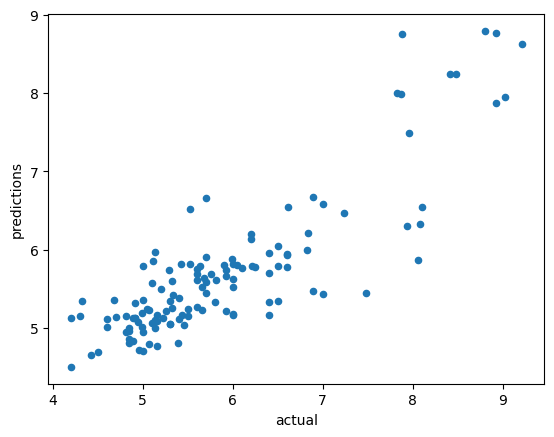

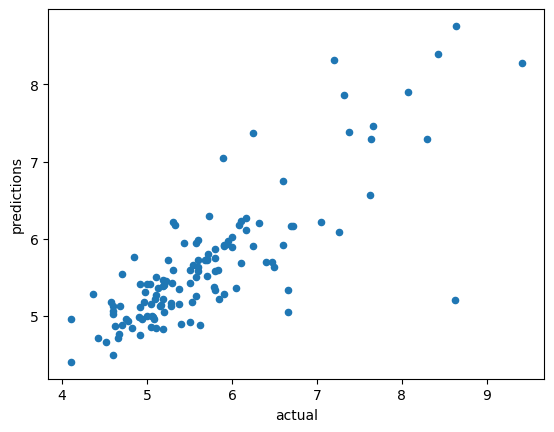

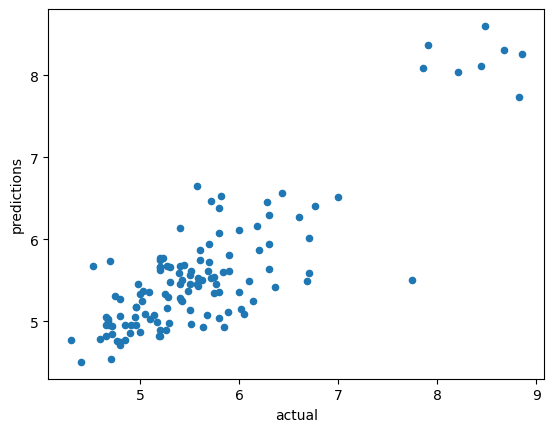

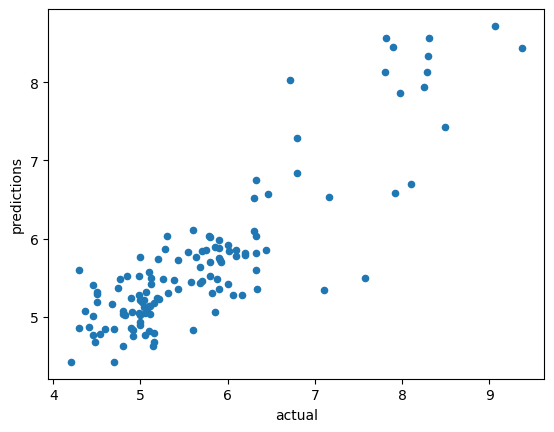

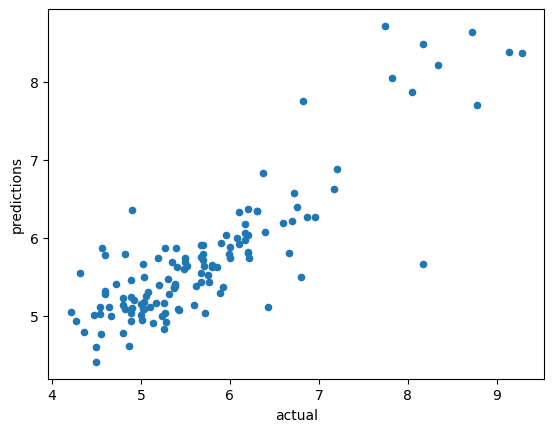

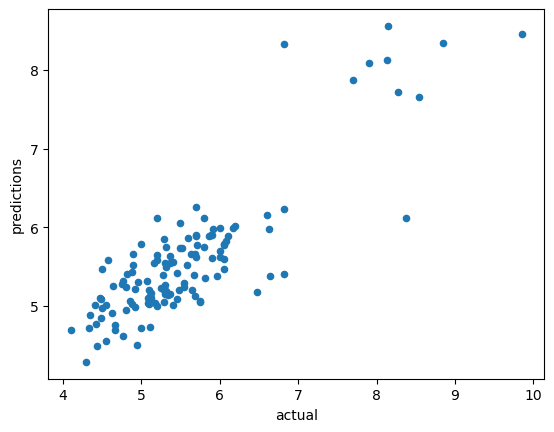

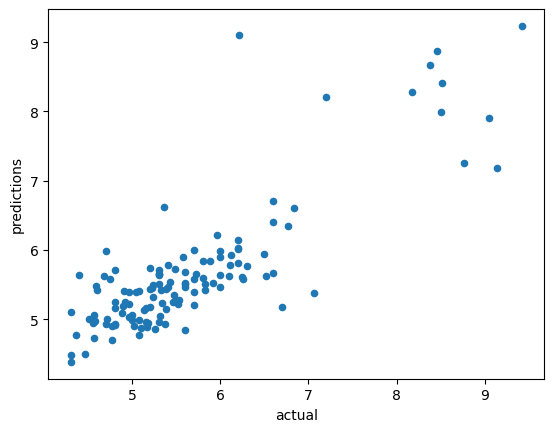

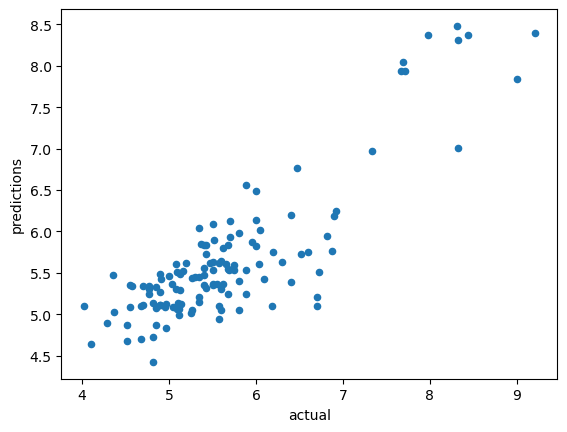

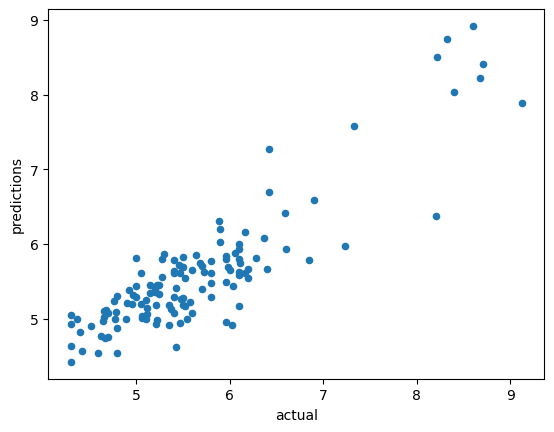

In [41]:
# Example Random Forest Model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
# Execute FCV sorted by target values (or another sorting metric if applicable)
results_df, false_disc, true_disc, true_ignore, false_ignore,rmse = perform_cv(X, y, smiles, sort_by=None, additional_info=df["QED"])

In [42]:
for i in np.arange(len(true_disc)):
    print(true_disc[i].shape)

(31, 3)
(32, 3)
(30, 3)
(38, 3)
(27, 3)
(32, 3)
(31, 3)
(26, 3)
(27, 3)


In [43]:
for i in np.arange(len(true_disc)):
    print(false_disc[i].shape)

(11, 3)
(8, 3)
(12, 3)
(2, 3)
(10, 3)
(14, 3)
(7, 3)
(9, 3)
(16, 3)


In [44]:
for i in np.arange(len(true_disc)):
    print(false_ignore[i].shape)

(10, 3)
(14, 3)
(9, 3)
(18, 3)
(17, 3)
(15, 3)
(14, 3)
(19, 3)
(13, 3)


In [45]:
for i in np.arange(len(true_disc)):
    print(true_ignore[i].shape)

(73, 3)
(70, 3)
(68, 3)
(67, 3)
(71, 3)
(61, 3)
(71, 3)
(71, 3)
(69, 3)


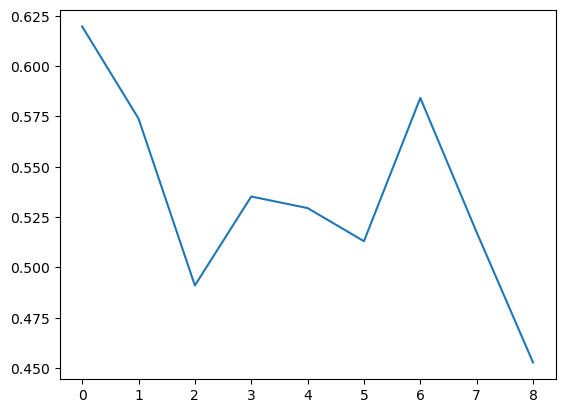

In [46]:
plt.plot(rmse)
plt.show()

In [47]:
def plot_graphs(data, results_df):
    
    results_df =pd.merge(data, results_df, 
                         left_on="Standardized_SMILES", right_on="Standardized_SMILES")
    
    # Calculate absolute errors and adjust results
    results_df['Error'] = (results_df['True Values'] - results_df['Predictions']).abs().round(2)
    results_df['True Values'] = results_df['True Values'].round(2)
    results_df['Predictions'] = results_df['Predictions'].round(2)

    # Plotting
    plt.figure(figsize=(15, 6))
    plt.scatter(results_df['MolWt'], results_df['Error'], color='blue', marker='o', s=15)
    plt.xlabel('Sorted By MolWt')
    plt.ylabel('Absolute Error')
    plt.xticks(rotation=45)  # Optional: Improve readability of x-axis labels
    plt.grid(True)  # Optional: Adds grid lines for better readability
    plt.show()
    
        # Plotting
    plt.figure(figsize=(15, 6))
    plt.scatter(results_df['QED'], results_df['Error'], color='blue', marker='o', s=15)
    plt.xlabel('Sorted By QED')
    plt.ylabel('Absolute Error')
    plt.xticks(rotation=45)  # Optional: Improve readability of x-axis labels
    plt.grid(True)  # Optional: Adds grid lines for better readability
    plt.show()
    
     # Plotting
    plt.figure(figsize=(15, 6))
    plt.scatter(results_df['LogP'], results_df['Error'], color='blue', marker='o', s=15)
    plt.xlabel('Sorted By LogP')
    plt.ylabel('Absolute Error')
    plt.xticks(rotation=45)  # Optional: Improve readability of x-axis labels
    plt.grid(True)  # Optional: Adds grid lines for better readability
    plt.show()
    
     # Plotting
    plt.figure(figsize=(15, 6))
    plt.scatter(results_df['pchembl_value'], results_df['Error'], color='blue', marker='o', s=15)
    plt.xlabel('Sorted By IC50 Sorted')
    plt.ylabel('Absolute Error')
    plt.xticks(rotation=45)  # Optional: Improve readability of x-axis labels
    plt.grid(True)  # Optional: Adds grid lines for better readability
    plt.show()

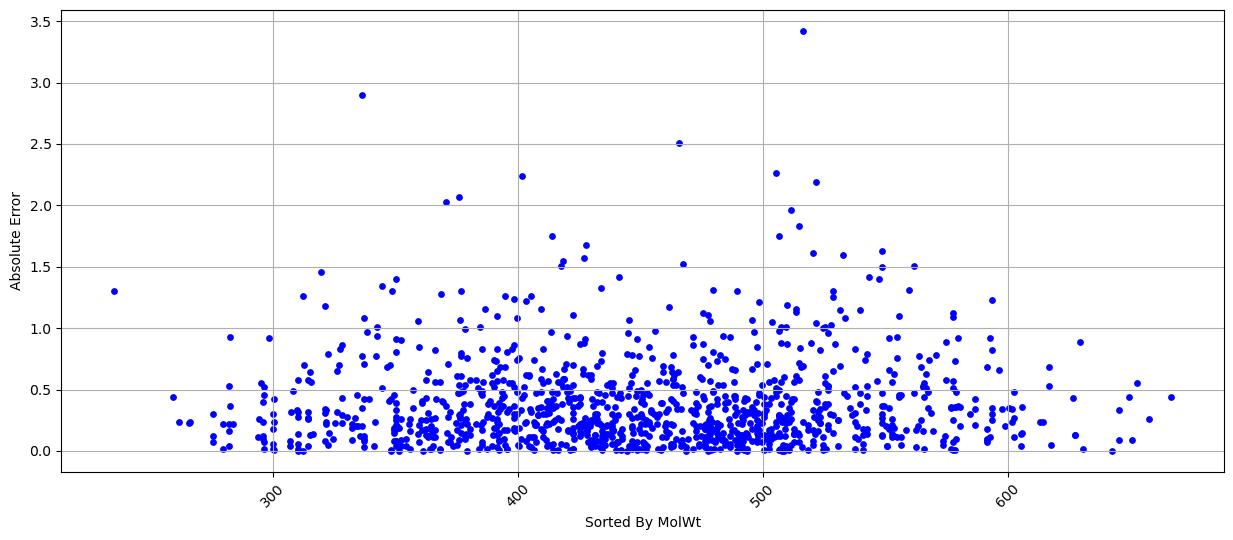

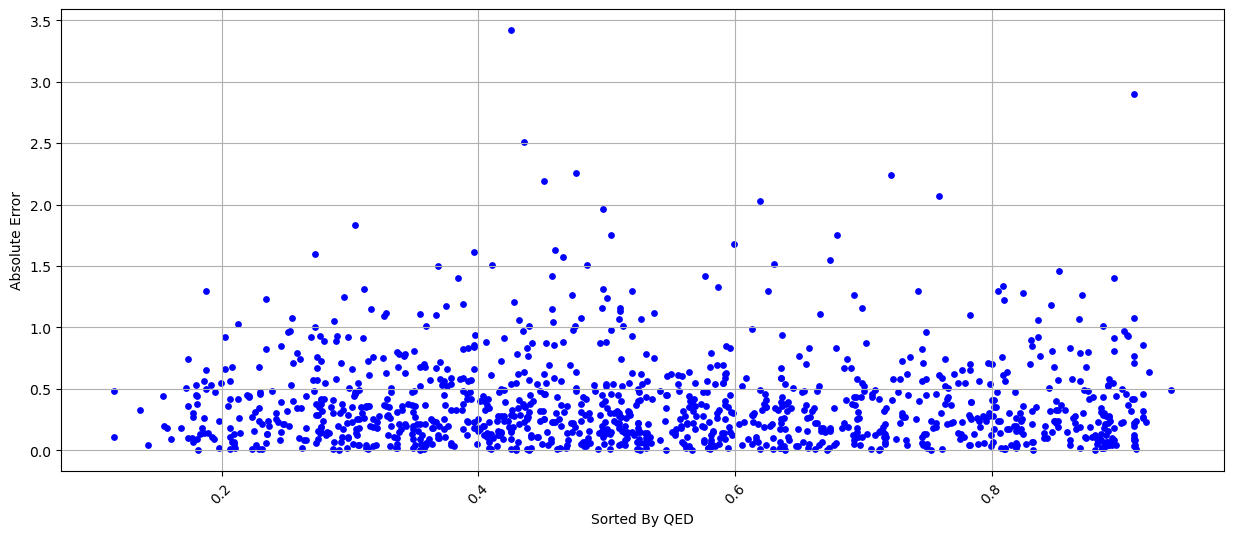

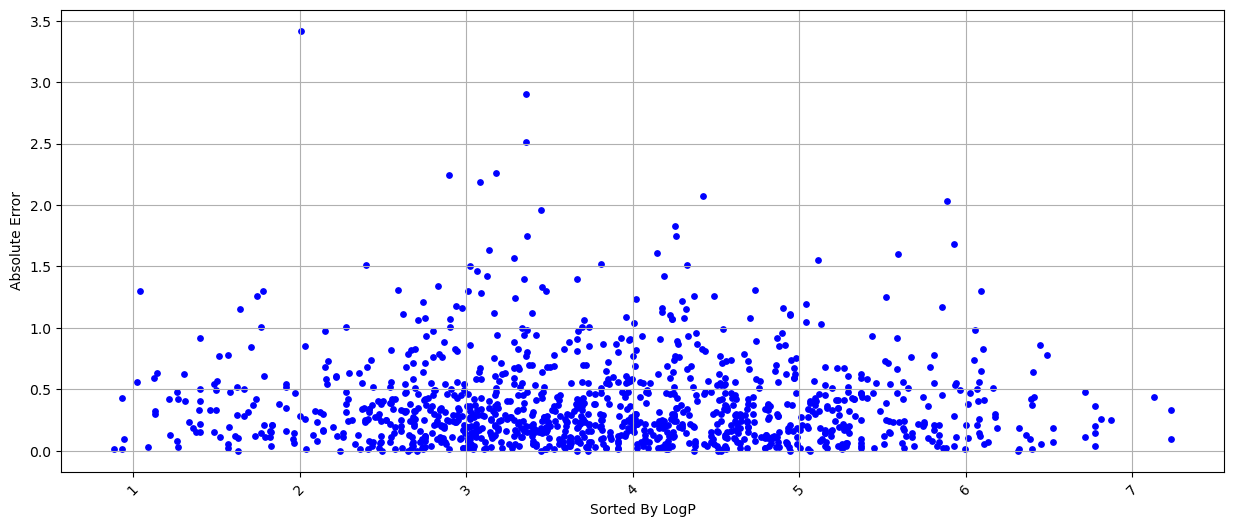

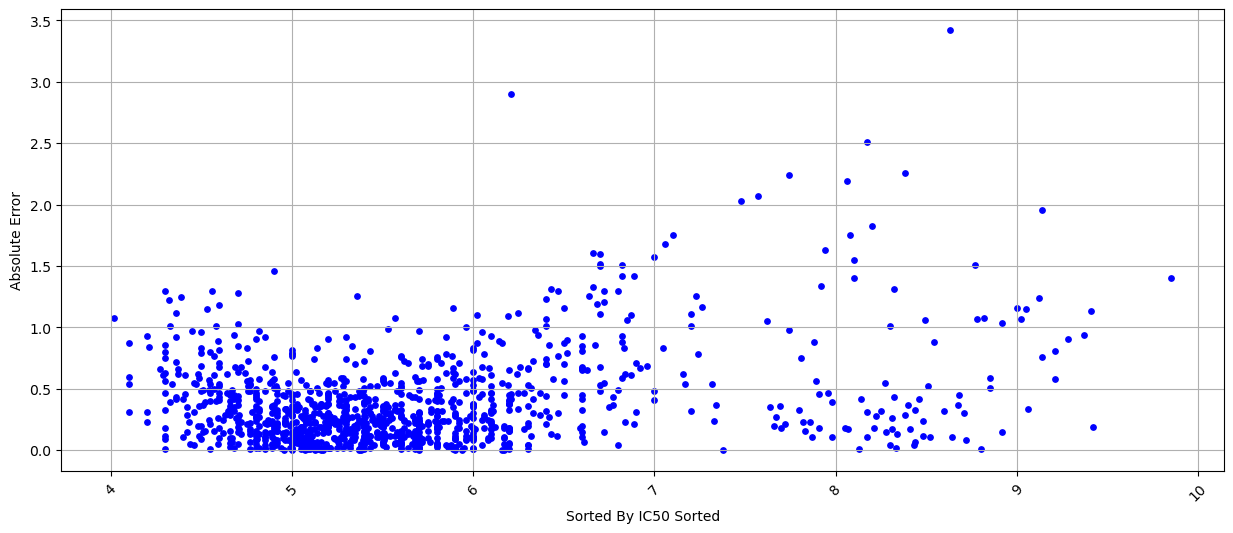

In [48]:
plot_graphs(df, results_df)

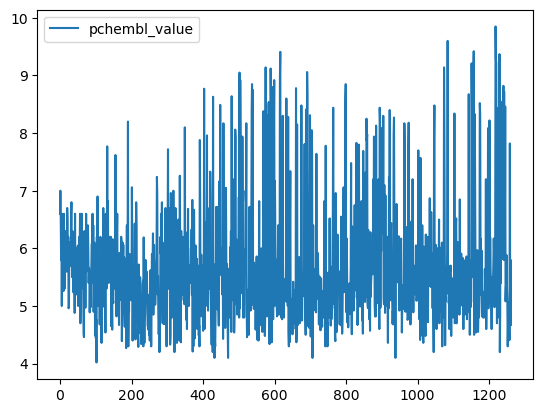

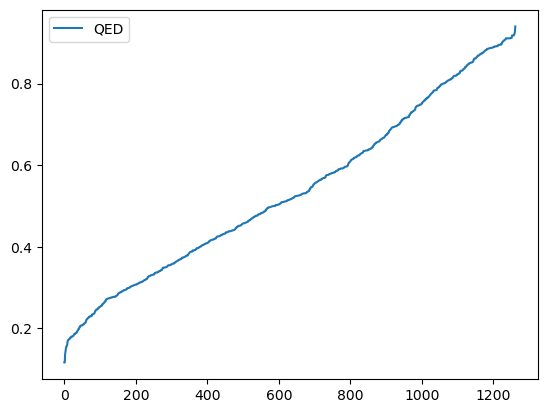

In [53]:
import random
df_copy=df.copy().sort_values(by="QED")#regular sort 
df_copy.plot(y="pchembl_value",use_index=False) #probabilities of each molecule being selected upon random selection without replacement
df_copy.plot(y="QED",use_index=False)

indices=df.nlargest(126, ['QED']).index
X_test=X.copy()[indices]
y_test=y.copy()[indices]
smiles_test=smiles[indices]

X1=np.delete(X.copy(),indices,axis=0)
y1=np.delete(y.copy(),indices,axis=0)
smiles1=np.delete(smiles.copy(),indices,axis=0)


#X[df.nlargest(126, ['QED']).index].shape

In [54]:
smiles1.shape

(1136,)

In [55]:
smiles_test.shape

(126,)

In [56]:
y_test.shape

(126,)

In [57]:
y1.shape

(1136,)

In [58]:
#Calculating Discovery metrics on most drug-like candidates

import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt

def perform_cv_on_most_druglike(X, y, smiles, k=10, sort_by=None, additional_info=None):
    false_discovery=list()
    true_discovery=list()
    true_ignore=list()
    false_ignore=list()
    rmse=list()
    if sort_by is not None:
        idx = np.argsort(sort_by)
        X, y, smiles = X[idx], y[idx], [smiles[i] for i in idx]
        if additional_info is not None:
            additional_info = [additional_info[i] for i in idx]


    predictions_all = []  # List to store all predictions
    true_values_all = []  # List to store all true values
    smiles_all = []       # List to store SMILES for each test sample
    sort_by_all = []      # List to store sort_by values for each test sample

    total_samples = len(X)
    fold_size = total_samples // k
    remainder = total_samples % k
    threshold=0
    for i in range(k-1):
        start = (i+1) * fold_size
        stop = ((i+1) + 1) * fold_size if (i+2) < k else total_samples
        
        X_train1 =np.vstack([X[:start]])
        X_train2=np.vstack([X[stop+1:]])
        X_train=np.vstack([X_train1,X_train2])
        
        y_train = np.delete(y.copy(), slice(start, stop + 1))
        sort_by_test = additional_info[start:stop] if additional_info is not None else y[start:stop]
        
        model = RandomForestRegressor(n_estimators=min(25,round(np.sqrt(X_train.shape[0]))), random_state=42, n_jobs=-1)
        model.fit(X_train, y_train)
        predictions = model.predict(X_test)
        print(stats.pearsonr(y_test, predictions))
        discoveries=pd.DataFrame({'Standardized_SMILES': smiles_test,'actual':y_test ,'predictions':predictions})
        discoveries.plot.scatter(x="actual",y="predictions",)#gonna subset this
        threshold=5.2 #previous max; discoveries defined as those who are predicted to be more than this
        discoveries=discoveries.query("predictions<@threshold")
        falses=discoveries.query("actual>@threshold")
        trues=discoveries.query("actual<@threshold")
        
        false_discovery.append(falses)
        true_discovery.append(trues)
        
        discoveries=pd.DataFrame({'Standardized_SMILES': smiles_test,'actual':y_test ,'predictions':predictions})#gonna subset this
        threshold=5.2 #previous max; discoveries defined as those who are predicted to be more than this
        discoveries=discoveries.query("predictions>@threshold")
        
        falses=discoveries.query("actual<@threshold")
        trues=discoveries.query("actual>@threshold")
        
        false_ignore.append(falses)
        true_ignore.append(trues)
        
        rmse.append(np.sqrt(mean_squared_error(y_test, predictions))) 
        predictions_all.extend(predictions.tolist())
        true_values_all.extend(y_test.tolist())
        smiles_all.extend(smiles_test)
        sort_by_all.extend(sort_by_test)

    # Optionally, save the results to a DataFrame

    # Saving to CSV (optional)
    

    # Return the DataFrame for further use or analysis
    return results_df,false_discovery,true_discovery, true_ignore, false_ignore,rmse

PearsonRResult(statistic=0.8273400857875837, pvalue=7.477746864495208e-33)
PearsonRResult(statistic=0.7994910217255939, pvalue=3.170974968610155e-29)
PearsonRResult(statistic=0.8226028270742544, pvalue=3.428728358673794e-32)
PearsonRResult(statistic=0.8368335056358316, pvalue=3.059846250774037e-34)
PearsonRResult(statistic=0.8569439690903278, pvalue=1.6868296505137764e-37)
PearsonRResult(statistic=0.7855928123524535, pvalue=1.2717241193002737e-27)
PearsonRResult(statistic=0.8548037440369876, pvalue=3.9530789723788074e-37)
PearsonRResult(statistic=0.8375574169923404, pvalue=2.378013141079611e-34)
PearsonRResult(statistic=0.8017606471875833, pvalue=1.6881306045953223e-29)


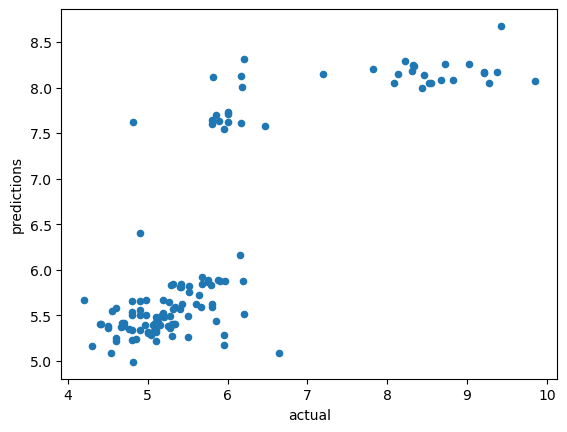

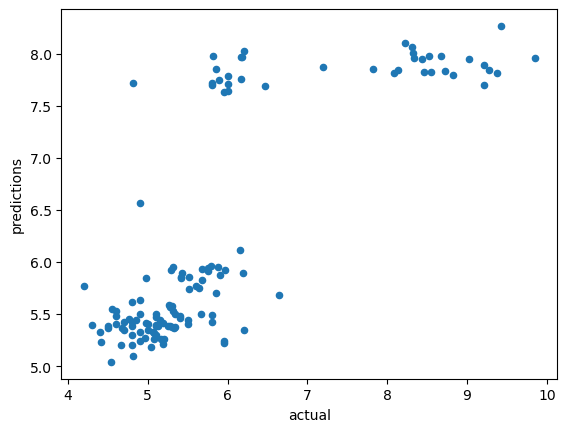

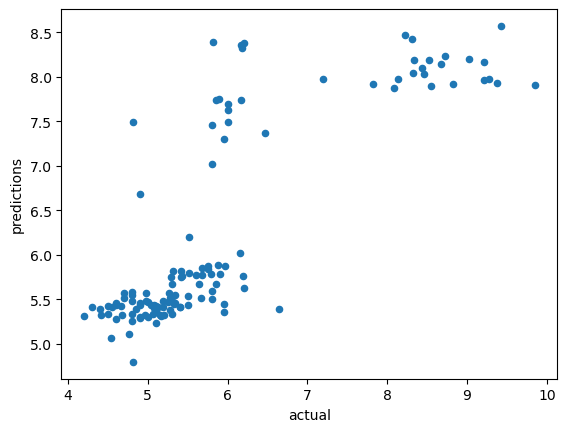

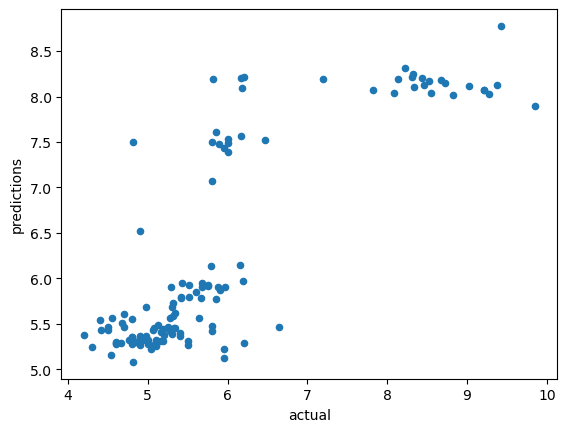

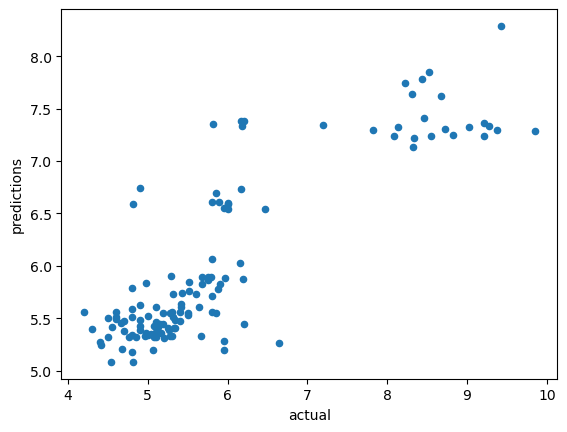

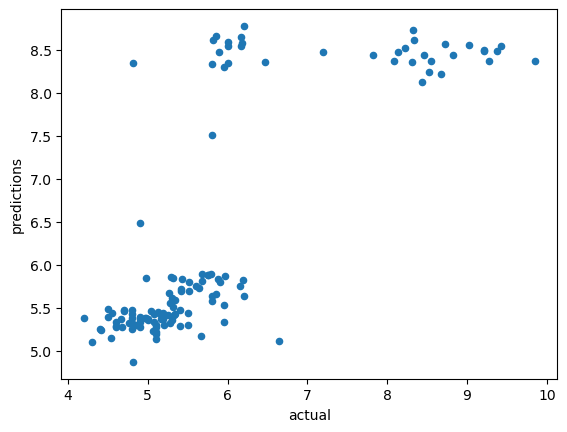

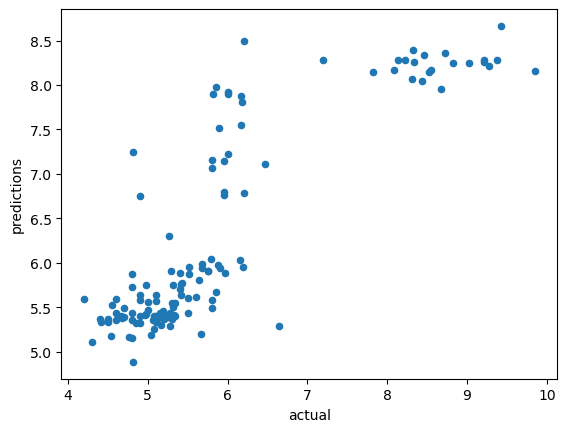

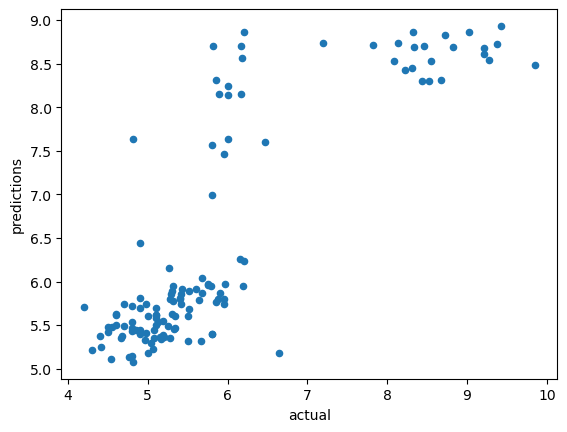

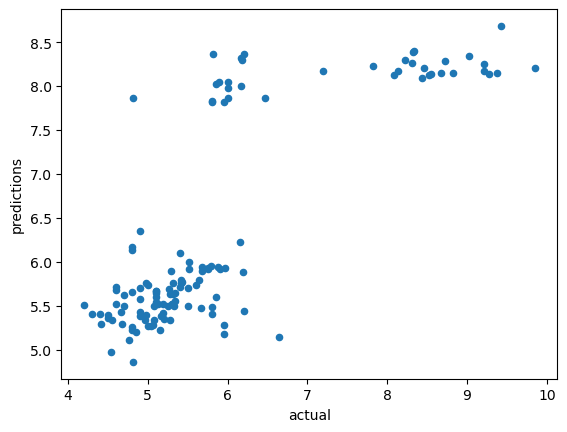

In [60]:

# Execute FCV sorted by target values (or another sorting metric if applicable)
results_df2, false_disc2, true_disc2, true_ignore2, false_ignore2,rmse = perform_cv_on_most_druglike(X1, y1, smiles1, sort_by=None, additional_info=df["QED"])

In [61]:
for i in np.arange(len(true_disc2)):
    print(true_disc2[i].shape)

(3, 3)
(3, 3)
(3, 3)
(2, 3)
(4, 3)
(4, 3)
(6, 3)
(5, 3)
(3, 3)


In [62]:
for i in np.arange(len(true_disc2)):
    print(false_disc2[i].shape)

(2, 3)
(0, 3)
(0, 3)
(1, 3)
(0, 3)
(2, 3)
(1, 3)
(1, 3)
(2, 3)


In [63]:
for i in np.arange(len(true_disc2)):
    print(true_ignore2[i].shape)

(75, 3)
(77, 3)
(77, 3)
(76, 3)
(77, 3)
(75, 3)
(76, 3)
(76, 3)
(75, 3)


In [64]:
for i in np.arange(len(true_disc2)):
    print(false_ignore2[i].shape)

(45, 3)
(45, 3)
(45, 3)
(46, 3)
(44, 3)
(44, 3)
(42, 3)
(43, 3)
(45, 3)


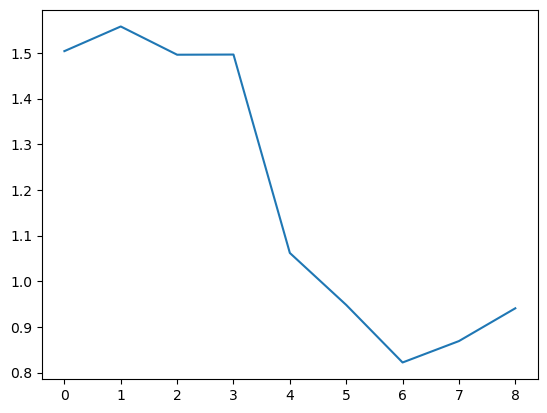

In [90]:
plt.plot(rmse)
plt.show()